In [2]:
import numpy as np
import pandas as pd
from code.load_data import Census_Data_Loader
from code.featurize import Featurize
import statsmodels.api as sm
import matplotlib.pyplot as plt
import statsmodels.stats.api as smf
from code.build_model import *
from scipy.stats import shapiro, kstest, anderson
from scipy.stats.mstats import normaltest
import math
%matplotlib inline
pd.options.display.max_rows = 999
import matplotlib.mlab as mlab

In [3]:
featurizer = Featurize()
print 'Loading Data...'
# 2012 Election Data
election_data = pd.read_csv('data/election_2012_cleaned.csv')
election_data.drop('Unnamed: 0', axis=1, inplace=True)
# 2013 ACS summary data
census_data = featurizer.load_summary_cols()
census_cols = featurizer.load_census_cols()
# 2013 Population Data
population = pd.read_csv('data/profile_census/census_pop.csv')
# 2013 Citizens of voting age by county
CVAP = featurizer.load_CVAP()
# Location of Field offices 2012
obama_offices = featurizer.load_offices('data/Obama_Office_Locations_Parsed_Cleaned.csv', suffix='dem')
romney_offices = featurizer.load_offices('data/Romney_Office_Locations_Parsed_Cleaned.csv', suffix='rep')
# Turnout by state
total_turnout = featurizer.load_turnout('data/turnout/total_turnout.csv', prefix='tot')
dem_turnout = featurizer.load_turnout('data/turnout/democratic_turnout.csv', prefix='dem')
rep_turnout = featurizer.load_turnout('data/turnout/republican_turnout.csv', prefix='rep')
# More county factors
education = featurizer.load_education()
# education = featurizer.normalize_by_col(education, cols=['Percent of adults with a high school diploma only, 2009-2013',
#                                                          'Percent of adults completing some college or associate\'s degree, 2009-2013',
#                                                          'Percent of adults with less than a high school diploma, 2009-2013',
#                                                          'Percent of adults with a bachelor\'s degree or higher, 2009-2013'], col='st_num')
unemployment = featurizer.load_unemployment()
# unemployment = featurizer.normalize_by_col(unemployment, cols=['Unemployment_rate_2013'], col='st_num')
poverty = featurizer.load_poverty()
# poverty = featurizer.normalize_by_col(poverty, cols=['PCTPOVALL_2013', 'PCTPOV017_2013'], col='st_num')

print 'Making df and fitting NMF...'
obama_df = make_joined_df(census_data, CVAP, dem_turnout, election_data, obama_offices, education, unemployment, poverty, featurizer, mod_type='dem', k=2)
#romney_df = make_joined_df(census_data, CVAP, rep_turnout, election_data, romney_offices, featurizer, mod_type='rep', k=5)

X_obama, y_obama, feat_names_obama = make_X_y(obama_df, mod_type='dem')
#X_romney, y_romney, feat_names_romney = make_X_y(romney_df, mod_type='rep')

Loading Data...
Making df and fitting NMF...


/Users/joelshuman/anaconda/lib/python2.7/site-packages/IPython/core/interactiveshell.py:3066: DtypeWarning: Columns (6,17) have mixed types. Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [4]:
X_obama_dropped = X_obama.drop(['CVAP_EST',
                        'dem_2008_delta',
                        'dem_2004_delta',
                        'dem_2000_delta',
                        'dem_1996_delta',
                        'dem_1992_delta',
                        'Percent of adults with a high school diploma only, 2009-2013',
                        'PCTPOVALL_2013',
                        'PCTPOV017_2013', 'rep_prez_amount', 'dem_prez_amount', 'Rep Cont % - Dem Cont %'], axis=1)
                        # 'dem_2004_delta',
                        # 'Percent of adults with less than a high school diploma, 2009-2013',
                        # 'Metro Bool',
                        # 'Unemployment_rate_2013'], axis=1)

In [5]:
def log_array(array):
    array = np.log(array)
    return np.nan_to_num(array)

def transform_cols(df, col_list):
    output = df.copy()
    for col in col_list:
        output[col] = df[col].apply(np.log)
    return output

col_list = ['dem_2012_p_vote','2013 Rural-urban Continuum Code',
           'Percent of adults with less than a high school diploma, 2009-2013',
            'Percent of adults with a bachelor\'s degree or higher, 2009-2013']

In [9]:
print 'Fitting models and printing results...'
mask = y_obama > 0
#X_obama_dropped['office_bool'] = X_obama_dropped['1_office'] + X_obama_dropped['2_office']
# .drop(['1_office', '2_office', 'cook_score'], axis=1)
# .drop('cook_score', axis=1)
X_obama_dropped['cook * office_bool'] = (X_obama_dropped['1_office'] + X_obama_dropped['2_office']) * X_obama_dropped['cook_score']

X_obama_dropped['dem_2012_p_vote'] = X_obama_dropped['dem_2012_p_vote'].apply(lambda x: max([x, 15]))
# X_obama_dropped['2013 Rural-urban Continuum Code'] = X_obama_dropped['2013 Rural-urban Continuum Code'].apply(lambda x: x > 3).astype(int)
# X_obama_dropped['cook_score'] = X_obama_dropped['cook_score'].apply(lambda x: max([x, -.4]))
# X_obama_dropped['dem_2012_p_vote'] = X_obama_dropped['dem_2012_p_vote'].apply(lambda x: min([x, 40]))
# X_obama_dropped['delta_vote_share'] = X_obama_dropped['delta_vote_share'].apply(lambda x: max([x, -.05]))
# X_obama_dropped['2013 Rural-urban Continuum Code'] = X_obama_dropped['2013 Rural-urban Continuum Code'].apply(lambda x: max([x, 2]))
# X_obama_dropped['Percent of adults with a bachelor\'s degree or higher, 2009-2013'] = X_obama_dropped['Percent of adults with a bachelor\'s degree or higher, 2009-2013'].apply(lambda x: max([x, 20]))
X_obama_dropped['relig_nmf_feat_0'] = X_obama_dropped['relig_nmf_feat_0'].apply(lambda x: min([x, 2]))

glsar_model = sm.GLSAR(y_obama[mask], X_obama_dropped[mask], rho=1)
glsar_results = glsar_model.iterative_fit(1)
print np.exp(glsar_results.params[-3:])
glsar_results.summary()
# donations by county / per capita by county
# ad spend
# q-q plot
# box plots predictor vs residuals

Fitting models and printing results...
1_office              1.008494
2_office              1.026978
cook * office_bool    1.053692
dtype: float64


<class 'statsmodels.iolib.summary.Summary'>
"""
                           GLSAR Regression Results                           
==============================================================================
Dep. Variable:                      y   R-squared:                       0.980
Model:                          GLSAR   Adj. R-squared:                  0.980
Method:                 Least Squares   F-statistic:                 1.124e+04
Date:                Fri, 08 Jan 2016   Prob (F-statistic):               0.00
Time:                        13:58:37   Log-Likelihood:                 5844.1
No. Observations:                3046   AIC:                        -1.166e+04
Df Residuals:                    3033   BIC:                        -1.158e+04
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
=====================================================================================================================================
                                                                        coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------------------------------------------------------------
dem_2012_p_vote                                                       0.0045      0.000     41.653      0.000         0.004     0.005
2013 Rural-urban Continuum Code                                       0.0047      0.000     17.248      0.000         0.004     0.005
Percent of adults with less than a high school diploma, 2009-2013     0.0004      0.000      3.235      0.001         0.000     0.001
Percent of adults with a bachelor's degree or higher, 2009-2013       0.0031   8.35e-05     37.230      0.000         0.003     0.003
Unemployment_rate_2013                                                0.0042      0.000     13.738      0.000         0.004     0.005
relig_nmf_feat_0                                                      0.0265      0.001     21.646      0.000         0.024     0.029
relig_nmf_feat_1                                                      0.0074      0.000     16.904      0.000         0.007     0.008
expenditure                                                       -3.712e-10   4.91e-11     -7.566      0.000     -4.67e-10 -2.75e-10
cook_score                                                            0.4855      0.006     80.280      0.000         0.474     0.497
delta_vote_share                                                      0.3442      0.023     15.017      0.000         0.299     0.389
1_office                                                              0.0085      0.002      3.618      0.000         0.004     0.013
2_office                                                              0.0266      0.004      7.466      0.000         0.020     0.034
cook * office_bool                                                    0.0523      0.016      3.189      0.001         0.020     0.084
==============================================================================
Omnibus:                      330.762   Durbin-Watson:                   1.612
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1845.226
Skew:                           0.358   Prob(JB):                         0.00
Kurtosis:                       6.745   Cond. No.                     5.74e+08
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.74e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Slope of best fit line: -26.303829921


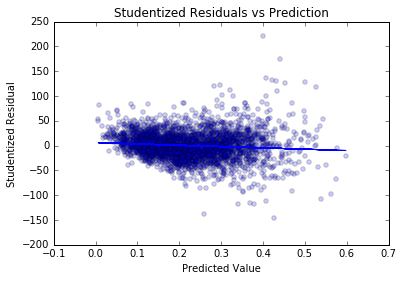

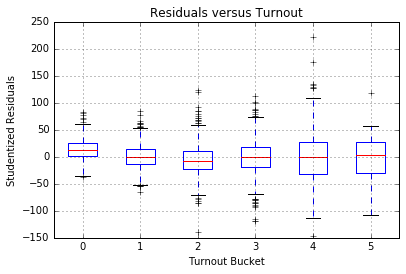

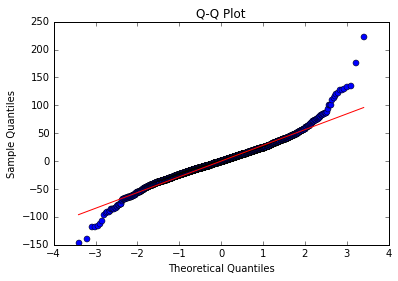

Shapiro-Wilk P_val is 1.12405406683e-25, larger the better
D’Agostino and Pearson’s P_val is 1.52241331342e-72, larger the better
Kolmogorov–Smirnov P_val is 0.0, larger the better
Anderson-Darling A2 is 12.4669037411, smaller the better
[ 0.575  0.655  0.786  0.917  1.091]
[ 15.   10.    5.    2.5   1. ]


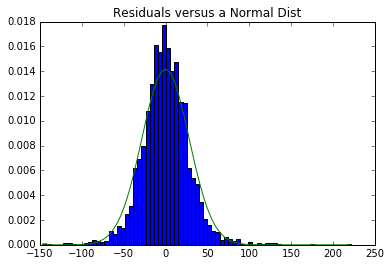

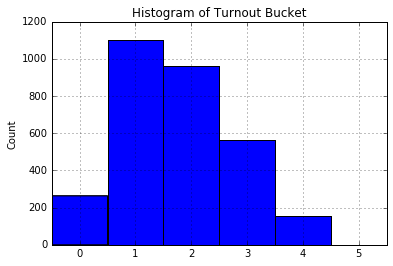

                Count
turnout_bucket       
0                 263
1                1101
2                 962
3                 564
4                 135
5                  22


In [10]:
plot_box_resids(glsar_results, glsar_results.fittedvalues, subset=None)

In [7]:
def plot_box_resids(fit_model, y_pred, subset=None):
    s_resid = (fit_model.resid - np.mean(fit_model.resid)) / np.var(fit_model.resid)
    if subset:
        s_resid = np.random.choice(s_resid, replace=False, size=math.floor(len(s_resid) * subset))
    df = pd.DataFrame(s_resid, columns=['resids'])
    temp_df = pd.DataFrame(y_pred, columns=['target'])
    df = df.join(temp_df)
    
    if min(y_pred) < -1:
        df['turnout_bucket'] = df['target'].apply(lambda x: int(math.floor(10 * np.exp(x))))
        y = df['target'].apply(lambda x: np.exp(x))
    else:
        df['turnout_bucket'] = df['target'].apply(lambda x: int(math.floor(10 * x)))
        y = df['target']

    posit = sorted(df['turnout_bucket'].unique())    

    plt.scatter(y, s_resid, alpha=.2)
    slope, intercept = np.polyfit(y, s_resid, 1)
    plt.plot(y, np.poly1d(np.polyfit(y, s_resid, 1))(y))
    plt.title('Studentized Residuals vs Prediction')
    plt.xlabel('Predicted Value')
    plt.ylabel('Studentized Residual')
    print 'Slope of best fit line: %s' % slope
    plt.show()
    
    #fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
    ax1 = df[['resids', 'turnout_bucket']].boxplot(by='turnout_bucket', positions=posit, widths=.5)
    plt.title('Residuals versus Turnout')
    plt.xlabel('Turnout Bucket')
    plt.ylabel('Studentized Residuals')
    plt.suptitle('')
    plt.show()
    
    fig = sm.qqplot(s_resid, line='s')
    plt.title('Q-Q Plot')
    plt.show()
    
    w, p_val = shapiro(s_resid)
    print 'Shapiro-Wilk P_val is %s, larger the better' % p_val
    
    k, p_val = normaltest(s_resid)
    print 'D’Agostino and Pearson’s P_val is %s, larger the better' % p_val
    
    k, p_val = kstest(s_resid, 'norm')
    print 'Kolmogorov–Smirnov P_val is %s, larger the better' % p_val
    
    A, critical, sig = anderson(s_resid)
    print 'Anderson-Darling A2 is %s, smaller the better' % A
    print critical
    print sig
    
    n, bins, patches = plt.hist(s_resid, 75, normed=1)
    mu = np.mean(s_resid)
    sigma = np.std(s_resid)
    plt.plot(bins, mlab.normpdf(bins, mu, sigma))
    plt.title('Residuals versus a Normal Dist')
    plt.show()
    
    df['turnout_bucket'].hist(bins=posit, align='left', color='b')
    plt.title('Histogram of Turnout Bucket')
    plt.ylabel('Count')
    plt.xlim(-.5, - .5 + len(posit))
    
    rects = df['turnout_bucket'].hist(bins=posit, align='left').patches
    temp = df[['resids', 'turnout_bucket']].groupby('turnout_bucket').count()
    temp.columns = ['Count']
    labels = temp.values
    
#     for rect, label in zip(rects, labels):
#         height = rect.get_height()
#         plt.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')
    
    plt.show()
    print temp
    
def plot_scatter(df, col, y):
    x = df[col]
    plt.scatter(x, y, alpha=.2)
    slope, intercept = np.polyfit(x, y, 1)
    plt.plot(x, np.poly1d(np.polyfit(x, y, 1))(x))
    plt.xlabel(col)
    plt.ylabel('Residuals')
    plt.title('%s versus Percent of vote' % col)
    print 'Slope = %s' % slope
    plt.show()

Slope = -0.000929001280077


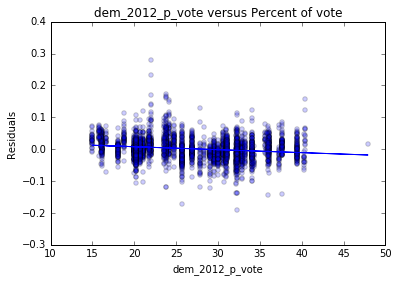

Slope = -0.00102838302689


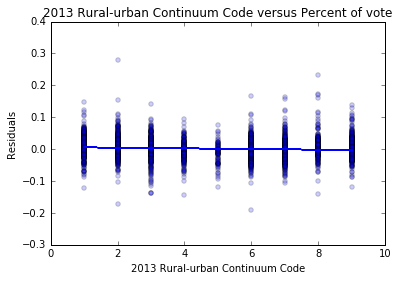

Slope = -0.000487536313123


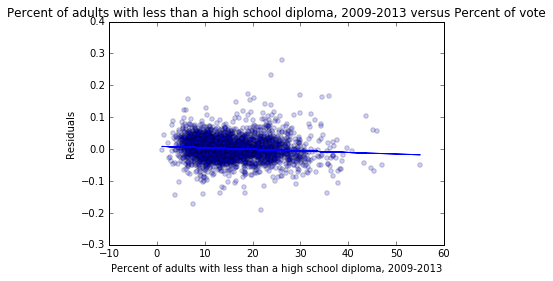

Slope = -0.00037730028126


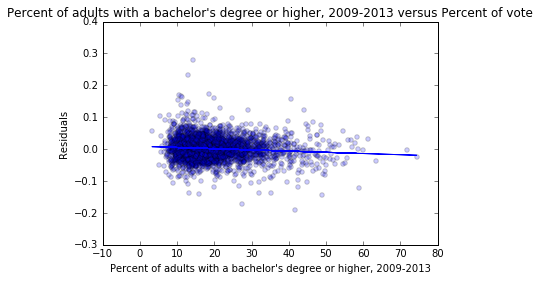

Slope = -0.00165582434629


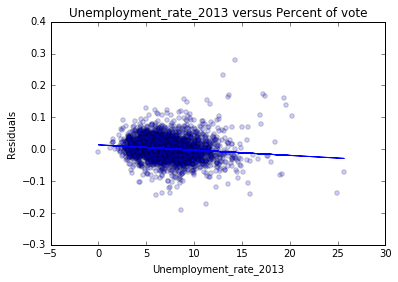

Slope = -0.00215481742732


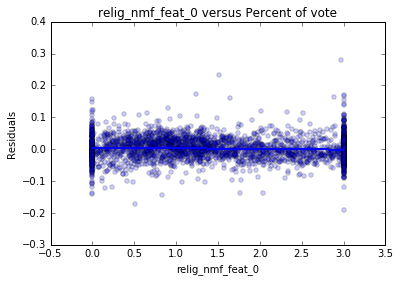

Slope = -0.000849705485217


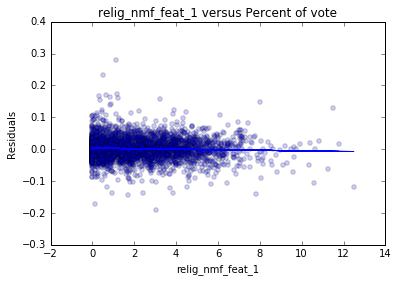

Slope = -5.05942881607e-11


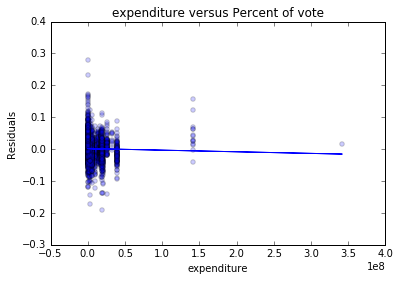

Slope = 0.00853515457778


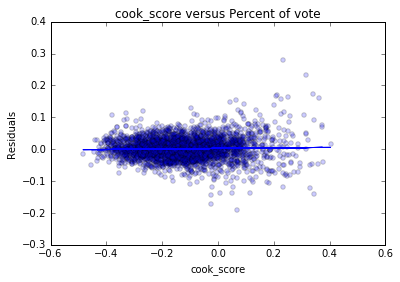

Slope = 0.0452108037755


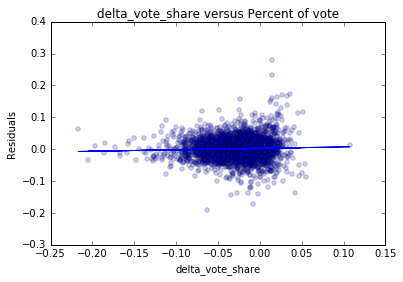

Slope = -0.00168790006847


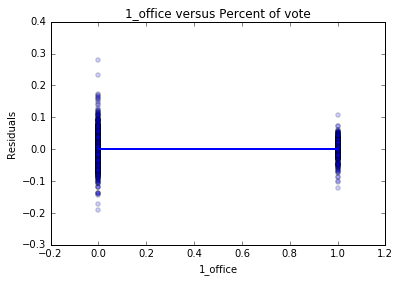

Slope = -0.00157418040017


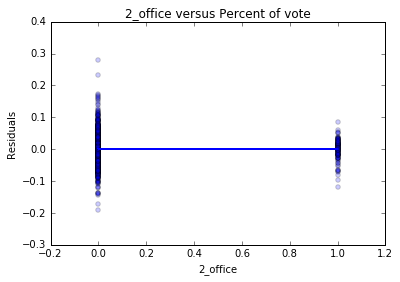

Slope = 7.01184796886e-05


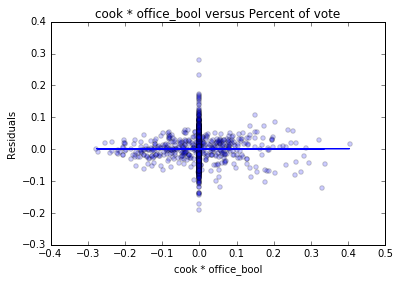

In [249]:
for feat in glsar_model.exog_names:
    plot_scatter(X_obama_dropped[mask], feat, glsar_results.resid)

Slope = 0.00903148323807


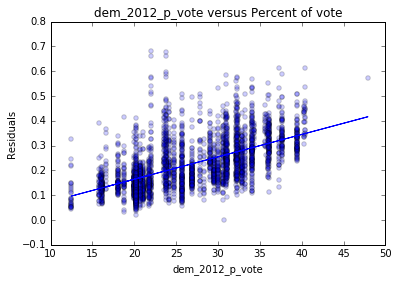

Slope = -0.00976489789784


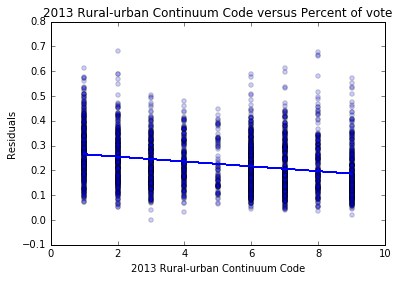

Slope = -0.00317131754375


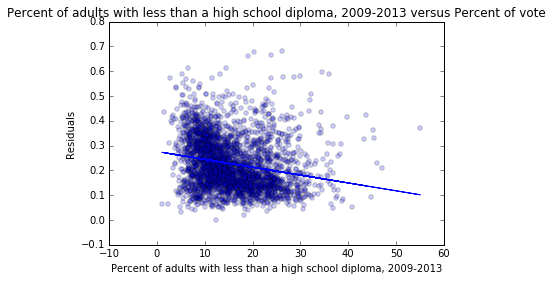

Slope = 0.00489352471884


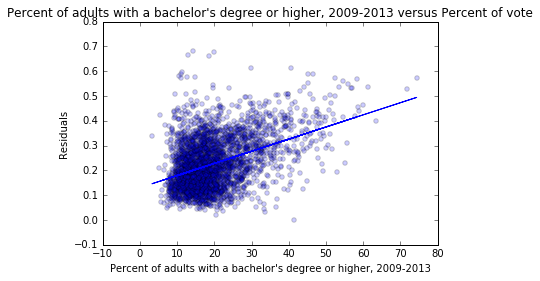

Slope = 0.00696538719407


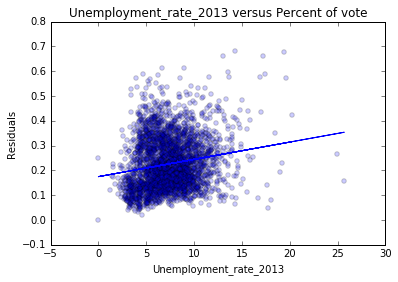

Slope = -0.0213332337084


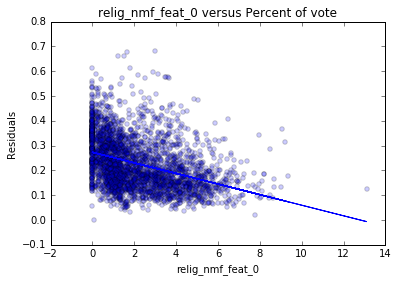

Slope = 0.0142585618051


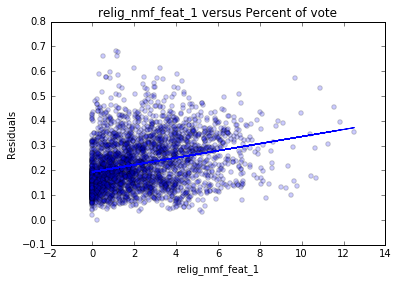

Slope = 1.69069958968e-09


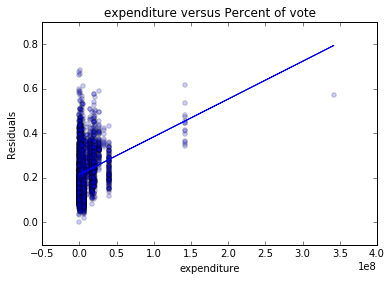

Slope = 1.20276327228


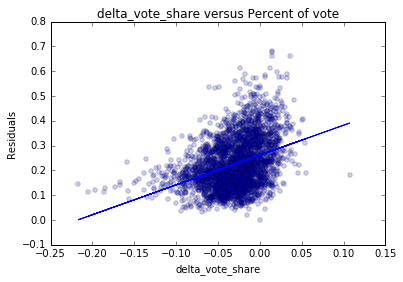

Slope = 0.095628777651


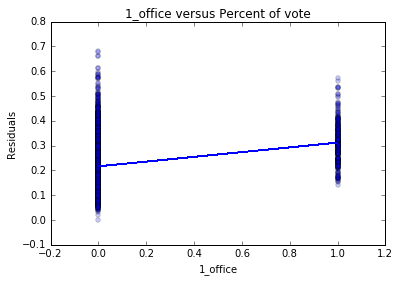

Slope = 0.142810563305


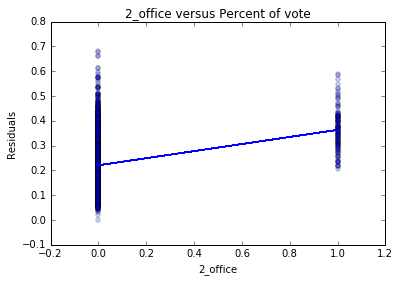

Slope = 0.655491043063


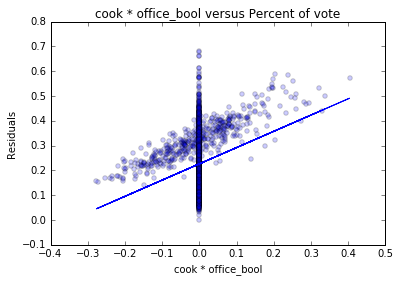

In [9]:
for feat in glsar_model.exog_names:
    plot_scatter(X_obama_dropped, feat, y_obama)

In [ ]:
import seaborn as sns
sns.pairplot(X_obama_dropped[mask].ix[:,:6], size=5)
plt.show()
sns.pairplot(X_obama_dropped[mask].ix[:,6:12], size=5)

In [250]:
def set_bucket(pred):
    if pred < .1:
        return 'Low'
    elif pred > .5:
        return 'High'
    else:
        return 'Average'
X_obama_dropped['pred'] = glsar_results.fittedvalues
X_obama_dropped['bucket'] = X_obama_dropped['pred'].apply(set_bucket)

In [253]:
def plot_hist(df, col, bucket):
    _, bins, _ = plt.hist(df[df[bucket]=='Average'][col])
    plt.close()

    for choice in df[bucket].unique():
        mask = df[bucket] == choice
        df[mask][col].hist(alpha=.4, label=str(choice), bins=bins)
    plt.yscale('log', nonposy='clip')
    plt.xlabel(col)
    plt.ylabel('Number')
    plt.title('%s Histogram by Turnout' % col)
    plt.legend()
    plt.show()
    
def plot_bucket_target(df, y, col, bucket):
    colors = ['b', 'g', 'y']
    alphas = [.1, .7, .7]
    markers = ['x', 'o', 'D']
    for i, choice in enumerate(df[bucket].unique()):
        mask = df[bucket] == choice
        plt.scatter(df[mask][col], y[mask.values], c=colors[i], label=str(choice), alpha=alphas[i], marker=markers[i])
    plt.xlabel(col)
    plt.ylabel('Target')
    plt.title('Target vs Predictors by Turnout')    
    plt.legend()
    plt.show()

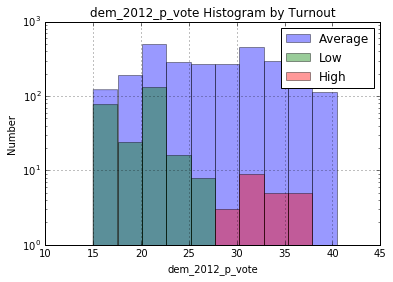

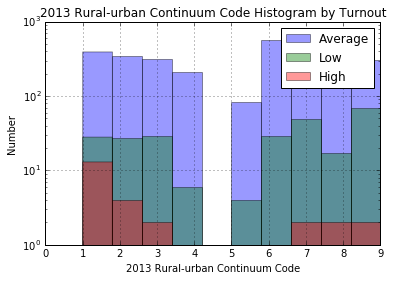

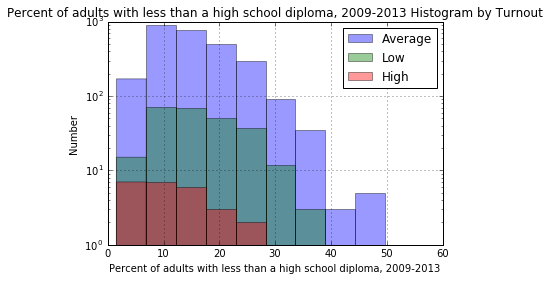

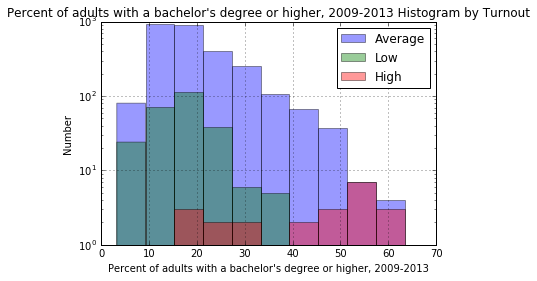

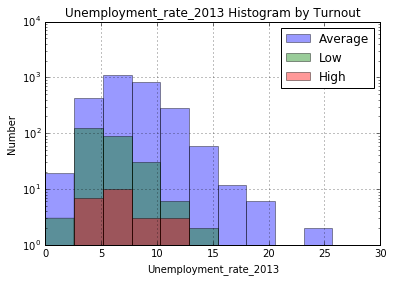

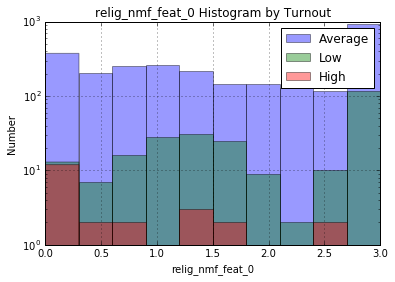

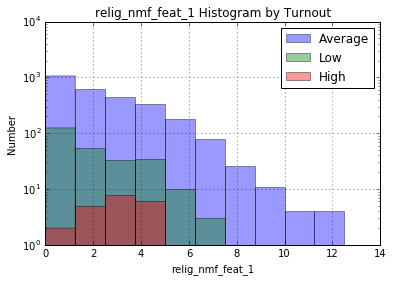

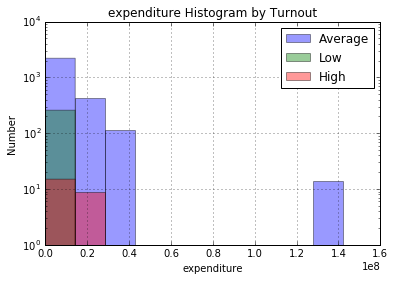

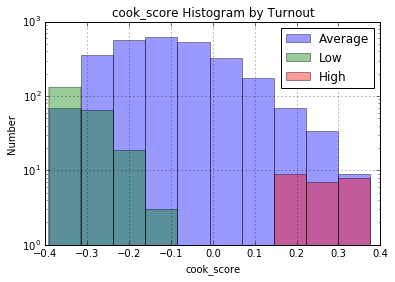

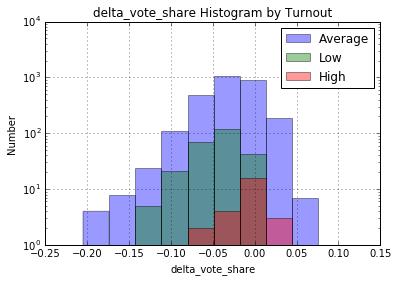

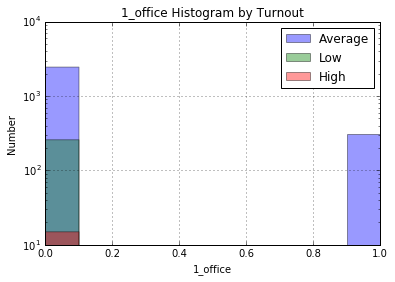

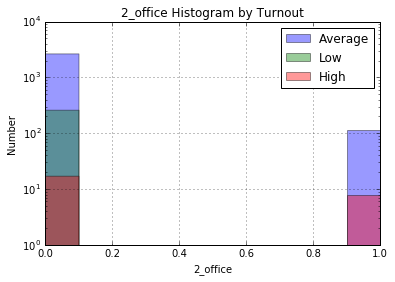

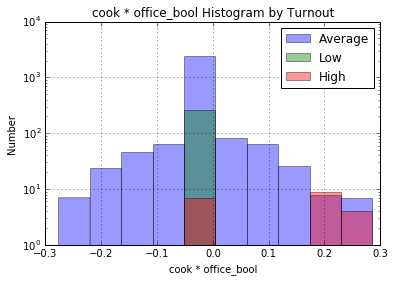

In [254]:
# Predictor Histograms by Turnout
for feat in glsar_model.exog_names:
    plot_hist(X_obama_dropped, feat, 'bucket')

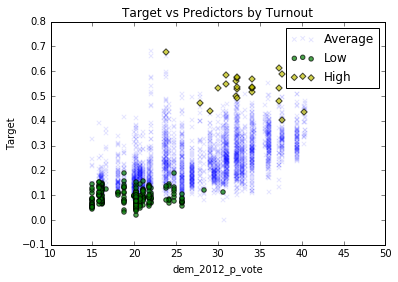

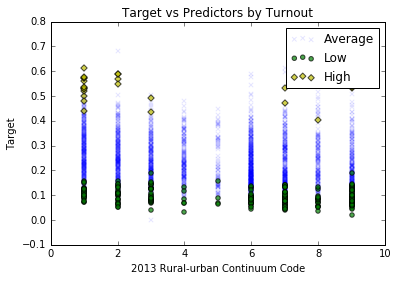

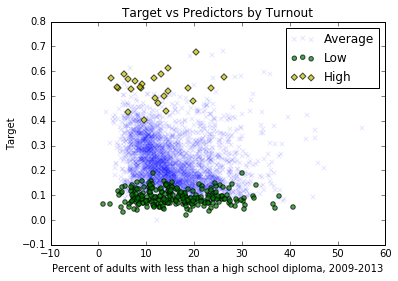

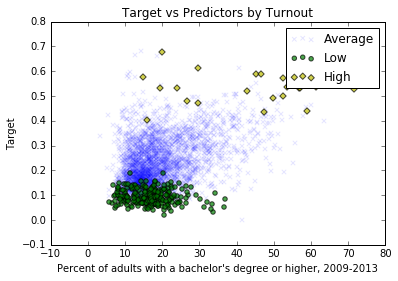

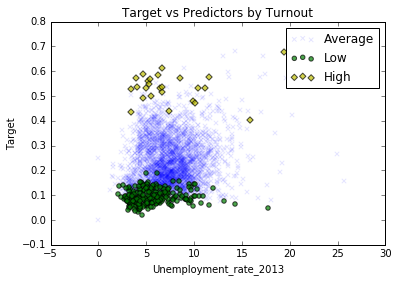

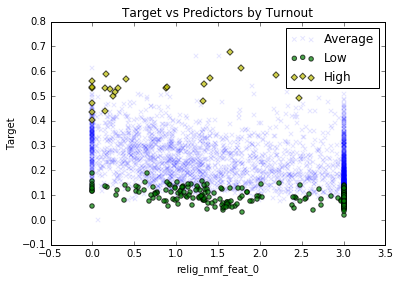

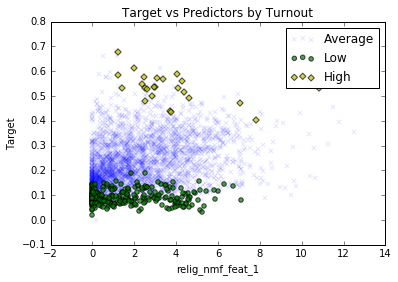

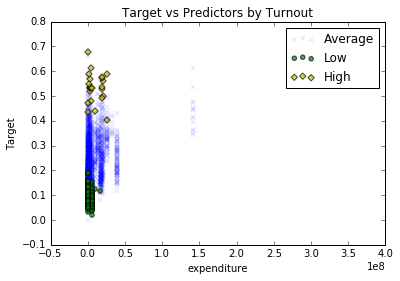

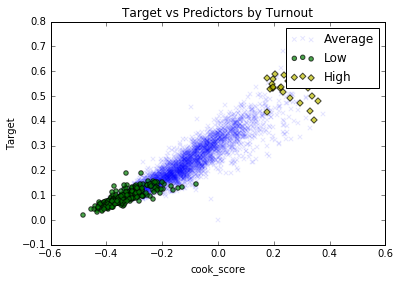

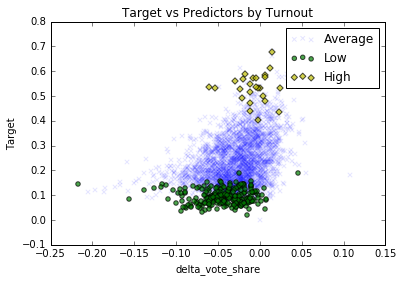

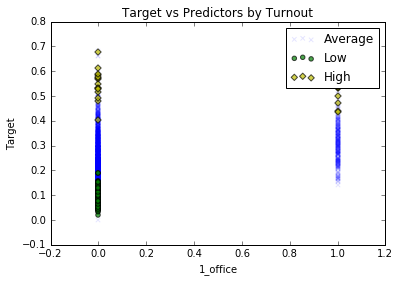

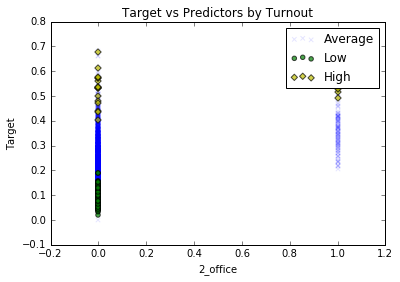

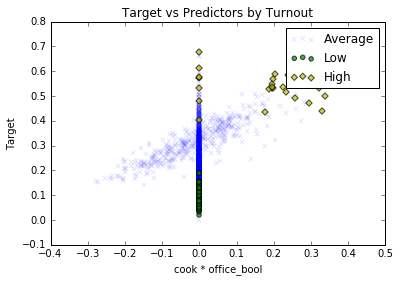

In [252]:
# Target vs Predictors Color Coded by Turnout Scatter Plots
for feat in glsar_model.exog_names:
    plot_bucket_target(X_obama_dropped, y_obama, feat, 'bucket')

In [66]:
y_obama.shape

(3048,)

In [73]:
mask = X_obama_dropped['bucket'] == 'Low'

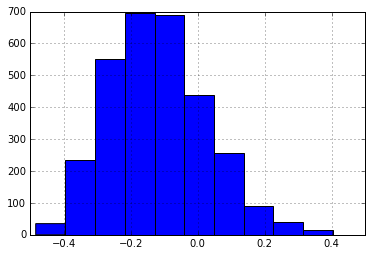

In [175]:
obama_df['cook_score'].hist()